# Automata and Life
Physics 481 Fall 2017 Week 3

au·tom·a·ton
ôˈtämədən,ôˈtäməˌtän
noun
plural noun: automata

 +a moving mechanical device made in imitation of a human being.
synonyms:	robot, android, cyborg, droid, bot
"assembly-line automatons"

 +a machine that performs a function according to a predetermined set of coded instructions, especially one capable of a range of programmed responses to different circumstances.
used in similes and comparisons to refer to a person who seems to act in a mechanical or unemotional way.

## Cellular automata

Read at least the first link:

    http://natureofcode.com/book/chapter-7-cellular-automata/

    https://plato.stanford.edu/entries/cellular-automata/index.html

    https://en.wikipedia.org/wiki/Cellular_automaton

in order to understand how to calculate and classify basic 1-dimensional automata.

Write a program to generate a sequence for $N=64$ grid cells and an arbitrary rule eg.

    ncells = 64
    state = np.zeros(ncells, dtype=np.int8 ) 
    state[ncells//2] = 1  # initialize one cell near the middle
  
    nsteps = 999
    for i in range(1,nsteps):
        state = cellular_step( state, rule=18)

Determine which 5 rules appear to be most random by estimating steady-state entropy after many steps.

Write a function to generate a pseudorandom sequence 64-bit integer based on a cellular automaton using the highest entropy rule.
  
Optional: read more about other examples and applications of cellular automata:  
  
    https://en.wikipedia.org/wiki/Nagel%E2%80%93Schreckenberg_model
  
    http://mathworld.wolfram.com/WireWorld.html  
  
  

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline



### decimal to binary

There are several different ways of converting a decimal integer into a binary value.  Perhaps the most obvious is "np.unpackbits" which returns a list of 0's and 1's.  The "np.binary_repr" function returns a string, as does "str.format" and the built-in "bin" function (although more work may be required to ensure leading 0's).

In the unlikely event that this operation is a computational bottleneck, we should probably use the "bin" method.  

Note: converting a string to a list of individual characters can be done with something like this:

        blist = []*len(s)
        for i,b in enumerate(s):
            blist[-i] = b

or:

        blist = []
        for b in s[::-1]:
            blist.append(b)

or:

        blist = [b for b in s][::-1] 

In [4]:
rule_number = 110
dec2bin = lambda x: np.unpackbits( np.uint8(x) )
print( dec2bin(rule_number) ) 
%timeit [dec2bin(rule_number) for rule_number in range(256)]

[0 1 1 0 1 1 1 0]
250 µs ± 9.75 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [5]:
dec2bin = lambda x: np.binary_repr(x, width=8)
print( dec2bin(rule_number) ) 
%timeit [dec2bin(rule_number) for rule_number in range(256)]

01101110
233 µs ± 882 ns per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [6]:
dec2bin = lambda x: '{:08b}'.format(x)
print( dec2bin(rule_number) ) 
%timeit [dec2bin(rule_number) for rule_number in range(256)]

01101110
107 µs ± 1.27 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [7]:
dec2bin = lambda x:  bin(rule_number)
print( dec2bin(rule_number) ) 
%timeit [dec2bin(rule_number) for rule_number in range(256)]

0b1101110
44.9 µs ± 391 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [8]:
dec2bin = lambda x:  bin(rule_number)[2:].zfill(8)
print( dec2bin(rule_number) ) 
%timeit [dec2bin(rule_number) for rule_number in range(256)]

01101110
101 µs ± 991 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


### 3-bit lookup

A 1-dimensional CA requires that we use 3-bits (left,middle,right) to look up the result for a given rule.

One way is to use a "dict" indexed by a tuple containing the three bits.  Another would be to convert the tuple into an integer in the range 0-7 and use that to index a list. The simplest and fastest approach is based on numpy array indexing, which is discussed in more detail below.

In [18]:
blist = np.unpackbits( np.uint8(rule_number) )

truple = [(0,0,0), (0,0,1), (0,1,0), (0,1,1), (1,0,0), (1,0,1), (1,1,0), (1,1,1)]

# we can generate an index to go with each value of a loop
#
lookup_dict = {}
for indx,lmr in zip(range(8),truple):
    lookup_dict[lmr] = blist[indx]

# or use enumerate to do the same thing automatically
#
lookup_dict = {}
for indx,lmr in enumerate(truple):
    lookup_dict[lmr] = blist[indx]


%timeit x = [ lookup_dict[i] for i in truple]
print([ lookup_dict[i] for i in truple] )

665 ns ± 5.12 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)
[0, 1, 1, 0, 1, 1, 1, 0]


In [19]:
blist = np.unpackbits( np.uint8(rule_number) )

lookup_list = [None]*8
for indx in range(8):
    lookup_list[indx] = blist[indx]
    
%timeit [lookup_list[i] for i in range(8)]

821 ns ± 10.4 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


In [21]:
blist = np.unpackbits( np.uint8(rule_number) )
lookup_array = np.array( blist, dtype=np.uint8 )
indx = np.arange(8,dtype=np.int)

%timeit x = [blist[i] for i in indx]
%timeit x = [lookup_array[i] for i in indx]
%timeit x = lookup_array[indx]

1.77 µs ± 8.02 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)
1.77 µs ± 4.36 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)
700 ns ± 1.29 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


### numpy array indexing

We can select individual elements from a list, or a range of elements

    list( [1,2,3,3] ) [1:3]
    
The same is true for Numpy arrays.  However, there are other ways to select elements.  A list or array of index values will result in a new array that is the same size as the index.  Each element will be the corresponding element of the original array. 

In [107]:
x = range(9) ; print(x)
print(x[0])
# print(x[0,2])
# print(x[ [0,2] ])

x = np.array(range(9)) ; print(x)
print(x[0])
#print(x[0,2])
print(x[ [0,2] ])
print(x[ [0,2,6,7] ])
print(x[ [0,2,0,4,0,6,0,8] ])

range(0, 9)
0
[0 1 2 3 4 5 6 7 8]
0
[0 2]
[0 2 6 7]
[0 2 0 4 0 6 0 8]


## Example cellular_step

In [ ]:
def cellular_step(value, rule_number=110):
    
    lookup = np.unpackbits( np.uint8(rule_number) )[::-1]
    triple = np.roll(value,+1)*4 + value*2 + np.roll(value,-1)
    
    return lookup[triple]

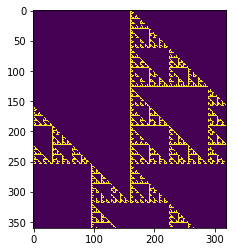

In [41]:
value = np.zeros(320, dtype=np.int8)
value[ len(value)//2 ] = 1

nsteps = 360
grid = np.ndarray( [nsteps, len(value)], dtype=np.int8)
for n in range(nsteps):
    value = cellular_step(value, rule_number=60)
    grid[n,:] = value
    
plt.imshow(grid)

In [97]:
nsteps = 9999
%prun for n in range(nsteps): value = cellular_step(value, rule_number=60)

## The game of life

Read this Wikipedia page: https://en.wikipedia.org/wiki/Conway%27s_Game_of_Life

Read the python file in D2L: phys481_game-of-life.py
and work your way through different implementations of the algorithm in stepper0, stepper1...
and play around with the results.

Examine the steady-state (long time) behaviour for an initial configuration with 1/2 the cells randomly turned on ($p=0.5$).
Calculate mean & standard deviation for at least 3 runs to estimate uncertainty.

Examine the steady-state behaviour for a range of initial random densities ranging from $p=0$ to $p=1$.
Discuss your results.

# import resources

The "import" command loads collections of code that are not part of the core python distribution.  We have used this to obtain plotting tools from matplotlib.pyplot and numerical tools from numpy.

For example, assume that the file "phys481_game_of_life.py" contains the python code as listed below.  Calling the import command will execute all the code in that file exactly as if we ran it from a Jupyter cell.  This can be used to define functions without taking up pages of space.

In [12]:
plist=[1/2,1/2,1/2,1/2,1/2]
H=0.0
for p in plist:
    H+=-np.log(p)*p/np.log(2)
H

2.5

In [13]:
plist=[2/5,1/5,1/5,1/5,1/5]
H=0.0
for p in plist:
    H+=-np.log(p)*p/np.log(2)
H

2.3863137138648347

In [122]:
import phys481_game_of_life

In [123]:
# %load phys481_game-of-life.py
"""
Created on Mon Oct 31 17:53:50 2016

@author: bjackel
"""

"""
# example with animation
grid = np.random.rand(401,501) > 0.5
p = plt.matshow(grid)
grid = life_generation_stepper(grid,nsteps=10000,plot=p)
"""

import numpy as np
import matplotlib.pyplot as plt


def life_generation_stepper(grid, nsteps=1, plot=None):
    
    # get most recently used plotting window
    fig = list(map(plt.figure, plt.get_fignums()))[-1]

    nx, ny = grid.shape
    x, y = np.meshgrid( np.arange(nx), np.arange(ny), indexing='ij' )
    xx = np.array([x+1, x-1, x+0, x+0, x+1, x-1, x+1, x-1]) % nx
    yy = np.array([y+0, y+0, y+1, y-1, y+1, y-1, y-1, y+1]) % ny

    for nstep in range(nsteps):
        nnear = np.sum( grid[xx,yy] , axis=0 )
        
        grid[(nnear < 2) | (nnear > 3)] = 0
        grid[nnear==3] = 1

        if plot is not None:
            plot.set_data(grid)
            plot.axes.set_title(str(nstep))
            fig.canvas.draw() ; fig.canvas.flush_events() #update plot window
   
    return grid

    
def stepper0(grid, nsteps=1, plot=None):
    """
    One step in Conway's game of life with wrap-around edges.
    
    Loop over all pixels in grid, and over all neighbors (very slow)
    """
    
    nx, ny = grid.shape
    xx, yy =  np.arange(nx), np.arange(ny) 
    newgrid = grid.copy()
    
    for x in xx:
        for y in yy:
            
            nnear = 0  # count number of neighbors
            
            for dx in [-1,0,1]:
                for dy in [-1,0,1]:
                    if (dx!=0 or dy!=0):  # don't include the cell itself
                        nnear += grid[ (x+dx)%nx, (y+dy)%ny ]

            # dead cells with three live neighbours become live cells
            if (grid[x,y] == 0):
                if nnear == 3:
                    newgrid[x,y]=1

            # live cells with fewer than two or more than 3 live neighbors die
            else:
                if nnear < 2:
                    newgrid[x,y]=0
                if nnear >3 :
                    newgrid[x,y]=0
                                                            
    return newgrid
    

def stepper1(grid, nsteps=1, plot=None):
    """
    One step in Conway's game of life with wrap-around edges.
    
    Loop over all pixels in grid, and then add all 8 neighbours (slow)
    """
    nx, ny = grid.shape
    xx, yy =  np.arange(nx), np.arange(ny) 
    newgrid = grid.copy()
    
    dx = np.array( [1, -1, 0, 0, 1, -1, 1, -1] )
    dy = np.array( [0, 0, 1, -1, 1, -1, -1, 1] )
               
    for x in xx:
        for y in yy:
            
            nnear = np.sum( grid[ (x+dx)%nx, (y+dy)%ny ] )
    
            if (nnear < 2) or (nnear > 3): 
                newgrid[x,y] = 0
            elif (nnear == 3):
                newgrid[x,y] = 1
                                            
    return newgrid    
    

def stepper2(grid, nsteps=1, plot=None):
    """
    One step in Conway's game of life with wrap-around edges.
    
    Loop over all neighbor shifts, adding an entire grid  (fast)
    """
    
    nx, ny = grid.shape
    xx, yy = np.meshgrid( np.arange(nx), np.arange(ny), indexing='ij' )

    nnear = 0
    newgrid = grid.copy()

    for dx in [-1,0,1]:
        for dy in [-1,0,1]:
            if (dx==0 and dy==0): continue
            nnear += grid[ (xx+dx)%nx,(yy+dy)%ny ]
    
    newgrid[(grid>0) & (nnear<2)] = 0
    newgrid[(grid>0) & (nnear>3)] = 0
    newgrid[(grid==0) & (nnear==3)] = 1
   
    return newgrid


def stepper3(grid, nsteps=1, plot=None):
    """
    One step in Conway's game of life with wrap-around edges.
    
    Try cleaning up the neighbour loops (faster?)
    """
    nx, ny = grid.shape
    xx, yy = np.meshgrid( np.arange(nx), np.arange(ny), indexing='ij' )
    dxy = [(1,0), (-1,0), (0,1), (0,-1), (1,1), (-1,-1), (1,-1), (-1,1) ]
    
    newgrid = grid.copy()           
    nnear = 0
    
    for dx,dy in dxy:
        nnear += grid[(xx+dx)%nx,(yy+dy)%ny] 
    
    newgrid[nnear < 2] = 0  
    newgrid[nnear > 3] = 0
    newgrid[nnear==3] = 1
   
    return newgrid


def stepper4(grid, nsteps=1, plot=None):
    """
    One step in Conway's game of life with wrap-around edges.
    
    -move more calculations outside loop (fastest?)
    -reuse input grid for output
    """
    nx, ny = grid.shape
    x, y = np.meshgrid( np.arange(nx), np.arange(ny), indexing='ij' )
    
    xx = np.array([x+1, x-1, x+0, x+0, x+1, x-1, x+1, x-1]) % nx
    yy = np.array([y+0, y+0, y+1, y-1, y+1, y-1, y-1, y+1]) % ny

    # grid[xx,yy].shape = 8,nx,ny  <= add up neighbours 
    # note: numpy will automatically convert boolean to integer before summing
    nnear = np.sum( grid[xx,yy] , axis=0 )
        
    grid[(nnear < 2) | (nnear > 3)] = 0
    grid[nnear==3] = 1

    return grid
    
    
      
# the code below will not run if this file is "included"
#
if __name__ == '__main__':

    print('Check agreement between different algorithms')
    grid = np.random.rand(31,21) >= 0.5  # don't use a square grid
    newgrid = stepper0(grid, nsteps=1)
    stepfunclist = [stepper0, stepper1, stepper2, stepper3, stepper4]
    
    for stepfunc in stepfunclist:
        test = stepfunc(grid)
        print( str(stepfunc), np.all(test == newgrid) )
        
    
    print('Compare speed of different algorithms (lower is better)')
    import timeit
    times = {}
    for stepfunc in stepfunclist:
        command = 'ng = {}(g)'.format(stepfunc.__name__)
        setup = 'from __main__ import {}; import numpy as np; g=(np.random.rand(31,21)>=0.5)'.format(stepfunc.__name__)
        times[stepfunc.__name__] = timeit.timeit(command,setup=setup, number=100)
    #t = timeit.timeit('ng = stepper0(grid)', setup='from __main__ import stepper0; import numpy as np; grid=np.random.rand(31,21)>=0.5', number=100)
    timeinfo = [ '{:9.5f} {}'.format(t,n) for (n,t) in times.items() ]
    print( '\n'.join( sorted(timeinfo) ) )
    
#newgrid = life_generation_stepper(grid, nsteps=1)
#p=plt.imshow(grid, interpolation='nearest')    
#p = plt.matshow(grid)
#newgrid = life_generation_stepper2(grid, nsteps=100, plot=p)
#p = plt.imshow(grid)
    

Check agreement between different algorithms
<function stepper0 at 0x7fc5a348aea0> True
<function stepper1 at 0x7fc5a348ac80> True
<function stepper2 at 0x7fc5a348abf8> True
<function stepper3 at 0x7fc5a348ab70> True
<function stepper4 at 0x7fc5a348a9d8> True
Compare speed of different algorithms (lower is better)
  0.01909 stepper4
  0.02042 stepper3
  0.02079 stepper2
  0.54507 stepper1
  0.83978 stepper0


## \_\_name\_\_ == \_\_main\_\_

Calling "import" will automatically execute everything in a python file.  Sometimes this is inconvenient.  For example, when writing and debugging a library we might want to run some tests or generate some plots to confirm that everything is working correctly.  However, some other user may want to import our library without running our diagnostic code.

One way to accomplish this might be to have some comments containing the test code.  We could uncomment it whenever we want to check that everything is okay, then turn it back into a comment when we were done.  This is a bit tedious and could cause problems if the code was imported while we were working on it.

One solution is to check whether the file is being run directly or as part of an import command.  This can be done by looking at the \_\_name\_\_ system variable which will only be set to \_\_main\_\_ if the file is *not* being imported.

In [124]:
print( __name__ )

__main__


In [113]:
#from pygments import highlight
#from pygments.lexers import PythonLexer
#from pygments.formatters import HtmlFormatter
#import IPython

#with open('phys481_game-of-life.py') as f:
#    code = f.read()

#formatter = HtmlFormatter()
#IPython.display.HTML('<style type="text/css">{}</style>{}'.format(
#    formatter.get_style_defs('.highlight'),
#    highlight(code, PythonLexer(), formatter)))